In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

games = pd.read_csv('./data/games.csv')
details = pd.read_csv('./data/games_details.csv')
injuries = pd.read_csv('./data/injuries_2010-2020.csv')

#Helper function to force pandas to display full dataframes
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [2]:
#We will drop the Acquired column for now, it might be possible to do analysis on 
#players returning from injuries but let's ignore it for now

injuries = injuries.drop('Acquired',axis=1)
injuries = injuries[injuries.Relinquished.notnull()]
injuries.update(injuries['Team'].fillna(value='No team', inplace=True))

#Charlotte Hornets were formerly the Bobcats before 2014, so we should count their injuries as
#part of the Hornets

injuries['Team'] = np.where((injuries.Team == 'Bobcats'), 'Hornets', injuries.Team)

#Let's copy the injuries dataset into a new dataframe
injuries_classes = injuries.copy()

#We'll use a lambda to create 3 different class labels for ML
injuries_classes['Notes'] = injuries_classes['Notes'].apply(lambda x: 
        1 if 'out for season' in x 
        else 1 if 'out indefinitely' in x
        else 1)
        
#Renaming the 'Notes' column to 'Class'
injuries_classes = injuries_classes.rename({'Notes': 'Injury', 'Relinquished': 'Player', 'year': 'Year'}, axis='columns')

#String formatting and removal of Jr. and periods from rows in Player column
injuries_classes['Player'] = injuries_classes['Player'].astype("string")
injuries_classes['Player'] = injuries_classes['Player'].str.replace('Jr.','')
injuries_classes['Player'] = injuries_classes['Player'].str.replace('.','')
injuries_classes['Player'] = injuries_classes['Player'].str.strip()

details['PLAYER_NAME'] = details['PLAYER_NAME'].astype("string")

#Formatting of both games and injuries to use pd Datetime format for merging
injuries_classes['Date'] = pd.to_datetime(injuries_classes['Date'],format='%Y-%m-%d')

games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'],format='%Y-%m-%d')

injuries_classes

,Date,Team,Player,Injury
0,2010-10-03,Bulls,Carlos Boozer,1
1,2010-10-06,Pistons,Jonas Jerebko,1
2,2010-10-06,Pistons,Terrico White,1
3,2010-10-08,Blazers,Jeff Ayres,1
4,2010-10-08,Nets,Troy Murphy,1
...,...,...,...,...
27097,2020-09-22,Celtics,Romeo Langford,1
27098,2020-09-23,Heat,Gabe Vincent,1
27099,2020-09-30,Heat,Bam Adebayo,1
27101,2020-10-02,Heat,Bam Adebayo,1


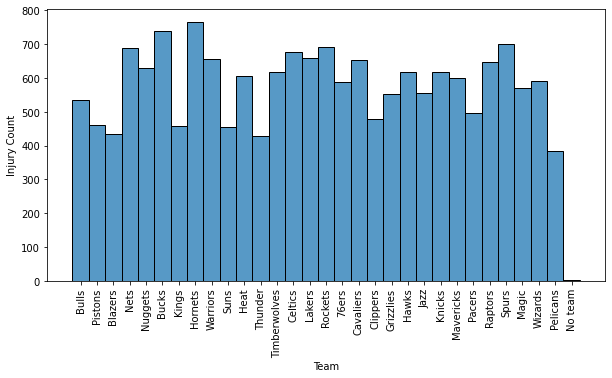

In [4]:
plt.figure(figsize=(10,5))
chart = sns.histplot(x='Team',data=injuries)
plt.xticks(rotation=90)
plt.ylabel('Injury Count')
plt.show()

In [5]:
games = games.drop_duplicates(subset=['GAME_ID'])
games = games[["GAME_DATE_EST","GAME_ID","SEASON"]]

In [6]:
df = games.sort_values(by=['GAME_DATE_EST'])
df[df.SEASON.astype(int) >= 2010]

,GAME_DATE_EST,GAME_ID,SEASON
7456,2010-10-04,11000003,2010
7448,2010-10-05,11000004,2010
7449,2010-10-05,11000007,2010
7450,2010-10-05,11000011,2010
7451,2010-10-05,11000006,2010
...,...,...,...
4,2021-05-25,42000152,2020
3,2021-05-25,42000112,2020
2,2021-05-26,42000142,2020
1,2021-05-26,42000132,2020


In [7]:
#Dataframes that are to be merged by merge_asof need to be sorted first
df = details.merge(games, on=['GAME_ID'])
df = df.sort_values(by=['GAME_DATE_EST'],ascending=True)
df

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,...,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,GAME_DATE_EST,SEASON
253897,10300001,1610612762,UTA,Utah,2260,Jarron Collins,NaN,NaN,5,2.0,...,2.0,0.0,0.0,0.0,2.0,2.0,4.0,NaN,2003-10-05,2003
253896,10300001,1610612762,UTA,Utah,731,Greg Ostertag,NaN,NaN,5,1.0,...,6.0,1.0,0.0,0.0,1.0,1.0,3.0,NaN,2003-10-05,2003
253889,10300001,1610612762,UTA,Utah,2144,Ademola Okulaja,NaN,NaN,5,1.0,...,1.0,1.0,0.0,0.0,1.0,2.0,2.0,NaN,2003-10-05,2003
253890,10300001,1610612762,UTA,Utah,1905,Andrei Kirilenko,NaN,NaN,5,0.0,...,5.0,2.0,2.0,1.0,4.0,1.0,1.0,NaN,2003-10-05,2003
253891,10300001,1610612762,UTA,Utah,1052,Ben Handlogten,NaN,NaN,5,2.0,...,6.0,0.0,0.0,0.0,2.0,4.0,4.0,NaN,2003-10-05,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,42000142,1610612763,MEM,Memphis,203937,Kyle Anderson,F,NaN,36:21,5.0,...,6.0,3.0,4.0,0.0,2.0,2.0,11.0,2.0,2021-05-26,2020
58,42000132,1610612752,NYK,New York,1629033,Theo Pinson,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-26,2020
57,42000132,1610612752,NYK,New York,203658,Norvel Pelle,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-26,2020
71,42000142,1610612763,MEM,Memphis,1629723,John Konchar,NaN,DNP - Coach's Decision,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-26,2020


In [8]:
asofmerge = pd.merge_asof(df, injuries_classes, left_on=['GAME_DATE_EST'], right_on=['Date'],direction='nearest',\
    left_by=['PLAYER_NAME'],right_by=['Player'],tolerance=pd.Timedelta("3D"))
asofmerge = asofmerge.sort_values(by=['GAME_DATE_EST'])
asofmerge['SEASON'] = pd.to_numeric(asofmerge['SEASON'])
asofmerge = asofmerge[asofmerge.SEASON >= 2010]
def formatInjury(x):
    if pd.isnull(x) : return 0
    else : return 1
s = asofmerge.loc[:,'Injury']
s = s.apply(formatInjury)
asofmerge['Injury'] = s
asofmerge = asofmerge.drop(['Player','Team','Date','START_POSITION','COMMENT','PLUS_MINUS'],axis=1)
asofmerge[['PLAYER_NAME','TEAM_CITY','GAME_DATE_EST','Injury','SEASON']]

,PLAYER_NAME,TEAM_CITY,GAME_DATE_EST,Injury,SEASON
234216,Trey Johnson,Los Angeles,2010-10-04,0,2010
234217,Theo Ratliff,Los Angeles,2010-10-04,0,2010
234218,Shannon Brown,Los Angeles,2010-10-04,0,2010
234220,Pau Gasol,Los Angeles,2010-10-04,0,2010
234221,Steve Blake,Los Angeles,2010-10-04,0,2010
...,...,...,...,...,...
615562,Taj Gibson,New York,2021-05-26,0,2020
615561,Alec Burks,New York,2021-05-26,0,2020
615560,Immanuel Quickley,New York,2021-05-26,0,2020
615557,Dwight Howard,Philadelphia,2021-05-26,0,2020


In [9]:
injuries_games = asofmerge.dropna(axis=0,how='any')
def seconder(x):
    if pd.isnull(x) : return 0
    elif ':' not in x :
        return x * 60
    else :
        mins, secs = map(float, str(x).split(':'))
        return mins * 60 + secs
s = injuries_games.loc[:,('MIN')]
s = s.apply(seconder)
s = s.convert_dtypes()
s = pd.to_numeric(s, errors='coerce').convert_dtypes()
injuries_games.loc[:,('MIN')] = s
injuries_games = injuries_games.rename({'MIN': 'SECS'}, axis='columns')

C:\Users\NJM\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [10]:
df = injuries_games.query('Injury == 1')
df = df.groupby(['SEASON','PLAYER_NAME'], as_index=False)['Injury'].count()
df = pd.merge(df,seasons_stats,left_on=['SEASON','PLAYER_NAME'],right_on=['season','player_name'])
df = df.drop(['player_name','season','team_abbreviation','college','country','draft_year','draft_round','draft_number','SEASON','PLAYER_NAME'],axis=1)
cols = list(df.columns.values)
inj = cols.pop(cols.index('Injury'))
df = df[cols+[inj]]
seasons_injuries = df

In [11]:
seasons_injuries

,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,Injury
0,24.0,187.96,82.100152,50,6.5,1.4,2.2,1.6,0.022,0.083,0.227,0.454,0.233,3
1,26.0,182.88,73.028312,59,10.7,1.3,3.9,-6.5,0.017,0.053,0.257,0.489,0.289,7
2,26.0,213.36,122.469840,41,3.1,4.2,0.4,2.2,0.140,0.273,0.132,0.566,0.044,4
3,26.0,190.50,91.625584,51,4.2,1.2,1.6,-8.2,0.019,0.082,0.160,0.502,0.182,3
4,31.0,205.74,113.398000,73,10.5,4.5,1.4,3.7,0.054,0.179,0.221,0.527,0.096,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3316,33.0,203.20,106.594120,35,5.9,4.1,1.1,-6.4,0.014,0.164,0.128,0.531,0.080,5
3317,22.0,210.82,113.398000,11,7.0,6.3,1.5,6.5,0.095,0.149,0.126,0.538,0.067,3
3318,25.0,198.12,90.718400,60,25.5,4.8,4.2,-4.4,0.019,0.125,0.312,0.568,0.218,1
3319,21.0,190.50,92.986360,7,1.1,0.3,0.3,-12.3,0.000,0.080,0.165,0.313,0.083,2


In [12]:
mldf = injuries_games.drop(['TEAM_ID','GAME_ID','PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','TEAM_CITY','GAME_DATE_EST','SEASON'],axis=1)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 2000)
#mldf['MIN'] = mldf['MIN'].astype(str)
cols = list(mldf.columns.values)
inj = cols.pop(cols.index('Injury'))
mldf = mldf[cols+[inj]]
#mldf = mldf.groupby(['Player']).transform(lambda x: x.fillna(x.mean()))
mldf

,SECS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,Injury
234216,1.313131e+119,4.0,7.0,0.571,0.0,0.0,0.000,0.0,0.0,0.000,0.0,1.0,1.0,2.0,1.0,0.0,1.0,4.0,8.0,0
234217,1.515152e+119,1.0,2.0,0.500,0.0,0.0,0.000,2.0,2.0,1.000,3.0,1.0,4.0,0.0,0.0,1.0,1.0,2.0,4.0,0
234218,2.525253e+119,6.0,10.0,0.600,1.0,2.0,0.500,0.0,0.0,0.000,2.0,2.0,4.0,2.0,1.0,0.0,0.0,1.0,13.0,0
234220,2.323232e+119,2.0,4.0,0.500,0.0,0.0,0.000,3.0,7.0,0.429,1.0,2.0,3.0,2.0,0.0,0.0,4.0,5.0,7.0,0
234221,2.020202e+119,2.0,5.0,0.400,1.0,1.0,1.000,0.0,0.0,0.000,0.0,1.0,1.0,4.0,0.0,1.0,2.0,4.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615562,1.814000e+03,3.0,4.0,0.750,0.0,0.0,0.000,0.0,0.0,0.000,4.0,3.0,7.0,1.0,3.0,1.0,0.0,1.0,6.0,0
615561,1.788000e+03,4.0,13.0,0.308,1.0,5.0,0.200,2.0,4.0,0.500,3.0,5.0,8.0,2.0,0.0,0.0,1.0,3.0,11.0,0
615560,8.710000e+02,2.0,9.0,0.222,0.0,4.0,0.000,0.0,0.0,0.000,0.0,3.0,3.0,1.0,1.0,0.0,1.0,2.0,4.0,0
615557,9.570000e+02,1.0,4.0,0.250,0.0,0.0,0.000,2.0,6.0,0.333,4.0,7.0,11.0,1.0,0.0,1.0,1.0,4.0,4.0,0


In [13]:
from scipy.stats import shapiro
alpha = 0.05
H0 = 'data is normally distributed'
Ha = 'data is not normally distributed'
def check_normality(df):
    for column, data in mldf.iteritems():
        print('n' + "*** Shapiro Test Results of '{}' ***".format(column))
        p = round(shapiro(data.values)[1], 2)
        if p <= alpha:
            print(f"{p} <= {alpha}. We reject null hypothesis. '{column}' {Ha}")
        else :
            print(f"{p} > {alpha}. We fail to reject null hypothesis. '{column}' {H0}")
check_normality(mldf)

n*** Shapiro Test Results of 'SECS' ***
1.0 > 0.05. We fail to reject null hypothesis. 'SECS' data is normally distributed
n*** Shapiro Test Results of 'FGM' ***
0.0 <= 0.05. We reject null hypothesis. 'FGM' data is not normally distributed
n*** Shapiro Test Results of 'FGA' ***
0.0 <= 0.05. We reject null hypothesis. 'FGA' data is not normally distributed
n*** Shapiro Test Results of 'FG_PCT' ***
0.0 <= 0.05. We reject null hypothesis. 'FG_PCT' data is not normally distributed
n*** Shapiro Test Results of 'FG3M' ***
0.0 <= 0.05. We reject null hypothesis. 'FG3M' data is not normally distributed
n*** Shapiro Test Results of 'FG3A' ***
0.0 <= 0.05. We reject null hypothesis. 'FG3A' data is not normally distributed
n*** Shapiro Test Results of 'FG3_PCT' ***
0.0 <= 0.05. We reject null hypothesis. 'FG3_PCT' data is not normally distributed
n*** Shapiro Test Results of 'FTM' ***
0.0 <= 0.05. We reject null hypothesis. 'FTM' data is not normally distributed
n*** Shapiro Test Results of 'FTA

C:\Users\NJM\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0 <= 0.05. We reject null hypothesis. 'REB' data is not normally distributed
n*** Shapiro Test Results of 'AST' ***
0.0 <= 0.05. We reject null hypothesis. 'AST' data is not normally distributed
n*** Shapiro Test Results of 'STL' ***
0.0 <= 0.05. We reject null hypothesis. 'STL' data is not normally distributed
n*** Shapiro Test Results of 'BLK' ***
0.0 <= 0.05. We reject null hypothesis. 'BLK' data is not normally distributed
n*** Shapiro Test Results of 'TO' ***
0.0 <= 0.05. We reject null hypothesis. 'TO' data is not normally distributed
n*** Shapiro Test Results of 'PF' ***
0.0 <= 0.05. We reject null hypothesis. 'PF' data is not normally distributed
n*** Shapiro Test Results of 'PTS' ***
0.0 <= 0.05. We reject null hypothesis. 'PTS' data is not normally distributed
n*** Shapiro Test Results of 'Injury' ***
0.0 <= 0.05. We reject null hypothesis. 'Injury' data is not normally distributed


No handles with labels found to put in legend.


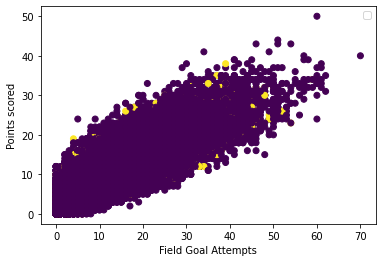

In [14]:
plt.scatter(mldf.loc[:,'PTS'], mldf.loc[:,'FGA'], c=mldf['Injury'], cmap='viridis')
plt.xlabel('Field Goal Attempts')
plt.ylabel('Points scored')
plt.legend()
plt.show()

In [27]:
#Machine Learning Section -- Random State = 24 for reproducibility
from sklearn.model_selection import train_test_split
#SKLearn imports of algorithms
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier,LogisticRegression,LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#For normalizing samples
from sklearn.preprocessing import StandardScaler, Normalizer
#Clustering
from sklearn.cluster import KMeans
#PCA
from sklearn.decomposition import PCA
#Pipeline
from sklearn.pipeline import Pipeline

#Models to apply to dataset
models = []
models.append(('LR', LogisticRegression(class_weight='balanced', random_state=24)))
models.append(('TREE', DecisionTreeClassifier(max_features='auto',class_weight='balanced',random_state=24)))
models.append(('SVC', LinearSVC(loss='squared_hinge',class_weight='balanced',dual=False,random_state=24)))
models.append(('SGD', SGDClassifier(loss='squared_hinge',max_iter=2000,penalty='l2',n_jobs=-1,class_weight='balanced',random_state=24)))
models.append(('FOREST', RandomForestClassifier(max_features='auto',class_weight='balanced',random_state=24)))
models.append(('LDA', LinearDiscriminantAnalysis()))

#Normalize
scaler = StandardScaler()
normalizer = Normalizer()

#Data matrices for classification
X = mldf.iloc[:,:19].values
y = mldf['Injury'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=24)

X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

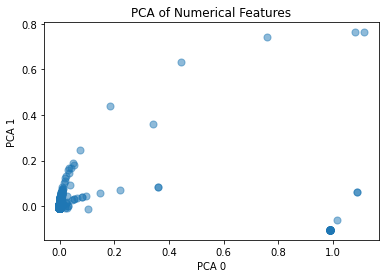

In [29]:
#PCA
N = 2
pca = PCA(n_components=N)
pca.fit(X_train)
columns = ['pca_%i' % i for i in range(N)]
X_train_trans = pca.transform(X_train)
df_pca = pd.DataFrame(X_train_trans, columns=columns)
plt.scatter(df_pca['pca_0'], df_pca['pca_1'], s=50, alpha=0.5)
plt.title('PCA of Numerical Features')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.show()

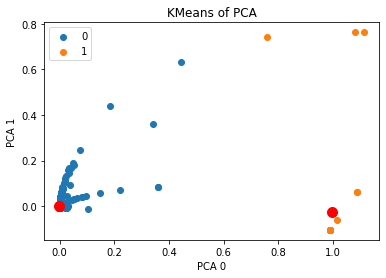

In [30]:
#Clustering
km = KMeans(n_clusters=2)
km.fit(df_pca)
label = km.fit_predict(df_pca)
u_labels = np.unique(label)
centroids = km.cluster_centers_

for i in u_labels:
    plt.scatter(df_pca.iloc[label == i,0],df_pca.iloc[label == i, 1], label=i)
    plt.scatter(centroids[i,0],centroids[i,1], s=100, c='red')
plt.title('KMeans of PCA')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.legend()
plt.show()

In [31]:
#KFold
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=5, random_state=24, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.541680 (0.003730)
TREE: 0.908201 (0.001558)
SVC: 0.551599 (0.002130)
SGD: 0.512511 (0.021119)
FOREST: 0.949355 (0.000202)
LDA: 0.950622 (0.000064)


In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Output all the results for each model

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"Accuracy for {name} is: {accuracy_score(y_test, predictions)}")
    print(f"Confusion Matrix for {name} is: \n {confusion_matrix(y_test, predictions)}")
    print(f"Classification Report for {name}: \n {classification_report(y_test, predictions)}")

Accuracy for LR is: 0.5427761770572777
Confusion Matrix for LR is: 
 [[98202 82182]
 [ 4461  4653]]
Classification Report for LR: 
               precision    recall  f1-score   support

           0       0.96      0.54      0.69    180384
           1       0.05      0.51      0.10      9114

    accuracy                           0.54    189498
   macro avg       0.51      0.53      0.40    189498
weighted avg       0.91      0.54      0.67    189498

Accuracy for TREE is: 0.9109278198186789
Confusion Matrix for TREE is: 
 [[172139   8245]
 [  8634    480]]
Classification Report for TREE: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95    180384
           1       0.06      0.05      0.05      9114

    accuracy                           0.91    189498
   macro avg       0.50      0.50      0.50    189498
weighted avg       0.91      0.91      0.91    189498

Accuracy for SVC is: 0.5517789105953624
Confusion Matrix for SVC is: 
 [

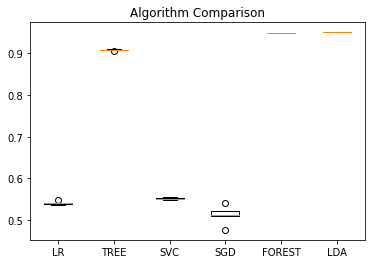

In [33]:
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

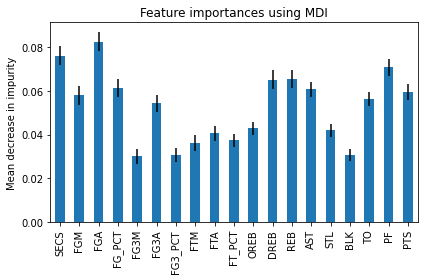

In [36]:
name, model = models[4]
forest = model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

columns = mldf.columns
columns = columns[:19]

forest_importances = pd.Series(importances, index=columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()